In [55]:
!pip install datasets

In [99]:
import datasets

from datasets import load_dataset

import numpy as np

import torch

import transformers

import torchvision

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)


In [64]:
model_checkpoint = "facebook/data2vec-vision-base-ft1k"

# model_checkpoint = "facebook/data2vec-vision-base"


https://huggingface.co/datasets/zh-plus/tiny-imagenet

In [50]:
tiny_imagenet = load_dataset('Maysee/tiny-imagenet')


In [51]:
tiny_imagenet

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [21]:
tiny_imagenet["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666347', 'n02669723', 'n02699494', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684', 'n02883205

In [62]:
labels = tiny_imagenet["train"].features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label


print(label2id['n01443537'])

print(id2label[0])



0
n01443537


In [65]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor



preprocessor_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [68]:
image_processor.size

{'height': 224, 'width': 224}

In [67]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None



In [69]:
train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )


In [70]:
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [90]:
# split up training into training + validation
# splits = tiny_imagenet["train"].train_test_split(test_size=0.1)
# train_ds = splits['train']
# val_ds = splits['test']


In [91]:
train_ds = load_dataset('Maysee/tiny-imagenet', split = "train")
val_ds = load_dataset('Maysee/tiny-imagenet', split = "valid")


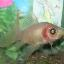

In [101]:
train_ds[0]["image"]

In [94]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [102]:
train_ds[0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [74]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)



config.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

Some weights of Data2VecVisionForImageClassification were not initialized from the model checkpoint at facebook/data2vec-vision-base-ft1k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

